In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import sys
sys.path.append('..')
# from modeling_rmt import RMTEncoderForSequenceClassification
# from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
import math
import torch
import torch.nn.functional as F

class RMTBaseModel(torch.nn.Module):
    def __init__(self, base_model, **rmt_kwargs):
        super().__init__()
        self.model = base_model
        self.set_params(**rmt_kwargs)

    def set_params(self, num_mem_tokens, tokenizer, **rmt_config):
        self.rmt_config = rmt_config
        self.extract_special_tokens(tokenizer)
        self.extend_word_embeddings(num_mem_tokens, tokenizer)

        self.segment_size = rmt_config['input_size'] - num_mem_tokens - tokenizer.num_special_tokens_to_add()
        if 'sep_token' in tokenizer.special_tokens_map:
            self.segment_size -= 1

    def set_memory(self, input_shape):
        memory = self.model.embeddings(self.mem_token_ids)
        memory = memory.repeat(input_shape[0], 1, 1)
        return memory

    def extract_special_tokens(self, tokenizer):
        self.pad_token_id = tokenizer.pad_token_id
        self.special_token_ids = [tokenizer.pad_token_id]
        for token in ['cls_token', 'sep_token', 'eos_token', 'bos_token']:
            token_id = getattr(tokenizer, f'{token}_id')
            if token_id is not None:
                self.register_buffer(token, torch.tensor([token_id]))
                self.special_token_ids.append(token_id)
            else:
                setattr(self, token, None)

    def extend_word_embeddings(self, num_mem_tokens, tokenizer):
            
        vocab_size = self.model.config.vocab_size
        extended_vocab_size = vocab_size + num_mem_tokens
        self.num_mem_tokens = num_mem_tokens
        self.register_buffer('mem_token_ids', torch.arange(vocab_size, vocab_size + num_mem_tokens))
        self.model.resize_token_embeddings(extended_vocab_size)

        special_tokens = tokenizer.special_tokens_map
        mem_start_ind = int('cls_token' in special_tokens or 'bos_token' in special_tokens)
        self.memory_position = range(mem_start_ind, mem_start_ind + num_mem_tokens)
        
        if hasattr(self.model.base_model, 'embeddings'): # enc-only
            self.model.embeddings = self.model.base_model.embeddings.word_embeddings
        elif hasattr(self.model.encoder, 'embed_tokens'): # enc-dec
            self.model.embeddings = self.model.encoder.embed_tokens
        else:
            raise NotImplementedError

    def forward(self, **kwargs):
       raise NotImplementedError

    def pad_and_segment(self, input_ids):
        segmented_batch = []
        for seq in input_ids:
            drop_mask = sum([seq == t for t in self.special_token_ids])
            seq = seq[(1 - drop_mask).bool()]
            seq = seq[:self.segment_size * self.rmt_config['max_n_segments']]

            align = self.rmt_config.get('segment_alignment')
            if align in {'right', None}:
                split_inds = (list(range(len(seq), 0, -self.segment_size)) + [0])[::-1]
                input_segments = [seq[start:end] for (start, end) in zip(split_inds, split_inds[1:])]
            elif align == 'left':
                split_inds = list(range(0, len(seq), self.segment_size)) + [len(seq)]
                input_segments = [seq[start:end] for (start, end) in zip(split_inds, split_inds[1:])]
            else:
                n_seg = math.ceil(len(seq) / self.segment_size)
                input_segments = torch.chunk(seq, n_seg)

            input_segments = [self.pad_add_special_tokens(t, self.rmt_config['input_size']) for t in input_segments]

            # add empty segment markers if needed
            n_empty_segments = self.rmt_config['max_n_segments'] - len(input_segments)
            input_segments = [None] * n_empty_segments + input_segments

            segmented_batch.append(input_segments)

        segmented_batch = [[sample[seg_num] for sample in segmented_batch] \
                            for seg_num in range(self.rmt_config['max_n_segments'])]
        return segmented_batch

    def pad_add_special_tokens(self, **kwargs):
        raise NotImplementedError

    def prepare_kwargs(self, segment_input_ids, kwargs):
        seg_kwargs = dict(**kwargs)
        non_empty_mask = [s is not None for s in segment_input_ids]
        if sum(non_empty_mask) == 0:
            return None, non_empty_mask
            
        input_ids = torch.stack([s for s in segment_input_ids if s is not None])
        inputs_embeds = self.model.embeddings(input_ids)

        seg_kwargs['input_ids'] = None
        seg_kwargs['inputs_embeds'] = inputs_embeds
        if seg_kwargs.get('labels') is not None:
            seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]
        seg_kwargs['attention_mask'] = self.get_attention_mask(input_ids)
        if seg_kwargs.get('token_type_ids') is not None:
            seg_kwargs['token_type_ids'] = self.get_token_type_ids(input_ids)
        seg_kwargs['output_hidden_states'] = True

        return seg_kwargs, non_empty_mask

    def process_outputs(self, model_outputs, output_attentions, output_hidden_states):
        rmt_out = model_outputs[-1]

        segment_keys = ['loss']
        if output_attentions:
            segment_keys.append('attentions')
        if output_hidden_states:
            segment_keys.append('hidden_states')

        extracted = {}
        for seg_num, out in enumerate(model_outputs):
            for key, value in out.items():
                if any([sk in key for sk in segment_keys]):
                    extracted[f'{key}_{seg_num}'] = value

        if self.rmt_config['sum_loss']:
            losses = [out['loss'] for out in model_outputs]
            extracted['loss'] = torch.stack(losses).mean(dim=0)

        for key, value in extracted.items():
            rmt_out[key] = value
        
        # drop unnecessary hiddens to save memory
        if not output_hidden_states:
            for key in rmt_out.keys():
                if 'hidden_state' in key:
                    rmt_out[key] = None

        return rmt_out 
        
    def get_token_type_ids(self, tensor):
        return torch.zeros_like(tensor)

    def get_attention_mask(self, tensor):
        mask = torch.ones_like(tensor)
        mask[tensor == self.pad_token_id] = 0
        return mask

In [4]:
num_segments = 2
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'

In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [10]:
import torch
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions

def memory_layers_forward_pe_mod(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        rmt_parent=None,
    ):
    # Model parallel
    if self.model_parallel:
        torch.cuda.set_device(self.first_device)
        self.embed_tokens = self.embed_tokens.to(self.first_device)
    use_cache = use_cache if use_cache is not None else self.config.use_cache
    output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
    output_hidden_states = (
        output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
    )
    return_dict = return_dict if return_dict is not None else self.config.use_return_dict

    if input_ids is not None and inputs_embeds is not None:
        err_msg_prefix = "decoder_" if self.is_decoder else ""
        raise ValueError(
            f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
        )
    elif input_ids is not None:
        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_shape[-1])
    elif inputs_embeds is not None:
        input_shape = inputs_embeds.size()[:-1]
    else:
        err_msg_prefix = "decoder_" if self.is_decoder else ""
        raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

    if inputs_embeds is None:
        assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
        inputs_embeds = self.embed_tokens(input_ids)

    batch_size, seq_length = input_shape

    # required mask seq length can be calculated via length of past
    mask_seq_length = past_key_values[0][0].shape[2] + seq_length if past_key_values is not None else seq_length
    

    if use_cache is True:
        assert self.is_decoder, f"`use_cache` can only be set to `True` if {self} is used as a decoder"

    if attention_mask is None:
        attention_mask = torch.ones(batch_size, mask_seq_length).to(inputs_embeds.device)
    if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
        encoder_seq_length = encoder_hidden_states.shape[1]
        encoder_attention_mask = torch.ones(
            batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
        )

    # initialize past_key_values with `None` if past does not exist
    if past_key_values is None:
        past_key_values = [None] * len(self.block)

    # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
    # ourselves in which case we just need to make it broadcastable to all heads.
    extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_shape, inputs_embeds.device)

    # If a 2D or 3D attention mask is provided for the cross-attention
    # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
    if self.is_decoder and encoder_hidden_states is not None:
        encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
        encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
        if encoder_attention_mask is None:
            encoder_attention_mask = torch.ones(encoder_hidden_shape, device=inputs_embeds.device)
        encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
    else:
        encoder_extended_attention_mask = None

    # Prepare head mask if needed
    head_mask = self.get_head_mask(head_mask, self.config.num_layers)
    cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.config.num_layers)
    present_key_value_states = () if use_cache else None
    all_hidden_states = () if output_hidden_states else None
    all_attentions = () if output_attentions else None
    all_cross_attentions = () if (output_attentions and self.is_decoder) else None
    # position_bias = None
    encoder_decoder_position_bias = None

    hidden_states = self.dropout(inputs_embeds)
    position_bias_ = rmt_parent.model.encoder.block[0].layer[0].SelfAttention.compute_bias(hidden_states.shape[1], hidden_states.shape[1])
    neighbour_bias = position_bias_[0, :, 1, 0]
    position_bias = torch.clone(position_bias_)

    for head_num, head_bias in enumerate(neighbour_bias):
        position_bias[:, head_num, rmt_parent.memory_position] = head_bias
        position_bias[:, head_num, :, rmt_parent.memory_position] = head_bias

    rmt_parent.encoder_position_bias = position_bias

    for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):
        layer_head_mask = head_mask[i]
        cross_attn_layer_head_mask = cross_attn_head_mask[i]
        # Model parallel
        if self.model_parallel:
            torch.cuda.set_device(hidden_states.device)
            # Ensure that attention_mask is always on the same device as hidden_states
            if attention_mask is not None:
                attention_mask = attention_mask.to(hidden_states.device)
            if position_bias is not None:
                position_bias = position_bias.to(hidden_states.device)
            if encoder_hidden_states is not None:
                encoder_hidden_states = encoder_hidden_states.to(hidden_states.device)
            if encoder_extended_attention_mask is not None:
                encoder_extended_attention_mask = encoder_extended_attention_mask.to(hidden_states.device)
            if encoder_decoder_position_bias is not None:
                encoder_decoder_position_bias = encoder_decoder_position_bias.to(hidden_states.device)
            if layer_head_mask is not None:
                layer_head_mask = layer_head_mask.to(hidden_states.device)
            if cross_attn_layer_head_mask is not None:
                cross_attn_layer_head_mask = cross_attn_layer_head_mask.to(hidden_states.device)
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if self.gradient_checkpointing and self.training:
            if use_cache:
                raise NotImplementedError
        else:
            layer_outputs = layer_module(
                hidden_states,
                attention_mask=extended_attention_mask,
                position_bias=position_bias,
                encoder_hidden_states=encoder_hidden_states,
                encoder_attention_mask=encoder_extended_attention_mask,
                encoder_decoder_position_bias=encoder_decoder_position_bias,
                layer_head_mask=layer_head_mask,
                cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=past_key_value,
                use_cache=use_cache,
                output_attentions=output_attentions,
            )
            
            ### Update memory
            memory_layer = rmt_parent.memory_layers[i]
            memory_layer_out = memory_layer(hidden_states, 
                                            attention_mask=extended_attention_mask,
                                            position_bias=position_bias,
                                            encoder_hidden_states=encoder_hidden_states,
                                            encoder_attention_mask=encoder_extended_attention_mask,
                                            encoder_decoder_position_bias=encoder_decoder_position_bias,
                                            layer_head_mask=layer_head_mask,
                                            cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                                            past_key_value=past_key_value,
                                            use_cache=use_cache,
                                            output_attentions=output_attentions,
            )
            memory = memory_layer_out[0][:, rmt_parent.memory_position]

        # layer_outputs is a tuple with:
        # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
        if use_cache is False:
            layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

        hidden_states, present_key_value_state = layer_outputs[:2]
        
        hidden_states[:, rmt_parent.memory_position] = memory

        # We share the position biases between the layers - the first layer store them
        # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
        # (cross-attention position bias), (cross-attention weights)
        position_bias = layer_outputs[2]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
        # append next layer key value states
        if use_cache:
            present_key_value_states = present_key_value_states + (present_key_value_state,)

        if output_attentions:
            all_attentions = all_attentions + (layer_outputs[3],)
            if self.is_decoder:
                all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

        # Model Parallel: If it's the last layer for that device, put things on the next device
        if self.model_parallel:
            for k, v in self.device_map.items():
                if i == v[-1] and "cuda:" + str(k) != self.last_device:
                    hidden_states = hidden_states.to("cuda:" + str(k + 1))

    hidden_states = self.final_layer_norm(hidden_states)
    hidden_states = self.dropout(hidden_states)

    # Add last layer
    if output_hidden_states:
        all_hidden_states = all_hidden_states + (hidden_states,)

    if not return_dict:
        return tuple(
            v
            for v in [
                hidden_states,
                present_key_value_states,
                all_hidden_states,
                all_attentions,
                all_cross_attentions,
            ]
            if v is not None
        )
    return BaseModelOutputWithPastAndCrossAttentions(
        last_hidden_state=hidden_states,
        past_key_values=present_key_value_states,
        hidden_states=all_hidden_states,
        attentions=all_attentions,
        cross_attentions=all_cross_attentions,
    )

In [11]:
from modeling_rmt import RMTEncoderDecoderMemoryLayers

In [12]:
# from rmt_utils.encoder_decoder.horizontal_memory import horizontal_memory_forward as memory_forward_func
# model_name = "facebook/bart-base"
model_name = 't5-small'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': 5, 
                'max_n_segments': 3,
               #  'segment_alignment': 'right',
                'tokenizer': tokenizer,
                'memory_layers': 'all', 
                'memory_forward_func': memory_layers_forward_pe_mod,
                'share_memory_layers': True,
                'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

base_model = T5ForConditionalGeneration.from_pretrained(model_name)

rmt = RMTEncoderDecoderMemoryLayers(base_model, **rmt_config)
rmt.to(device)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(


In [19]:
out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
out.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states', 'loss_0', 'loss_1', 'loss_2'])

In [21]:
rmt.encoder_position_bias.shape

torch.Size([1, 8, 512, 512])

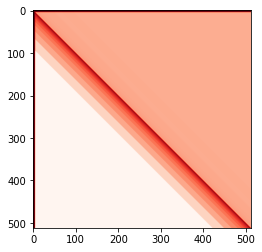

In [25]:
plt.imshow(rmt.encoder_position_bias[0, 0].detach(), cmap='Reds')

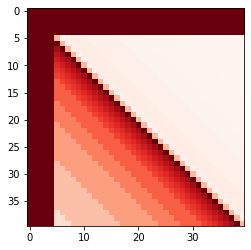

In [26]:
plt.imshow(rmt.encoder_position_bias[0, 0, :40, :40].detach(), cmap='Reds')

In [49]:
pos_bias = rmt.model.encoder.block[0].layer[0].SelfAttention.compute_bias(512, 512)

In [50]:
new_bias = torch.clone(pos_bias)

In [44]:
neighbour_bias = pos_bias[0, :, 1, 0]
# pos_bias[:, :, rmt.memory_position] = neighbour_bias

In [51]:
neighbour_bias = pos_bias[0, :, 1, 0]
new_bias = torch.clone(pos_bias)

for head_num, head_bias in enumerate(neighbour_bias):
    new_bias[:, head_num, rmt.memory_position] = head_bias
    new_bias[:, head_num, :, rmt.memory_position] = head_bias

In [52]:
pos_bias = new_bias

In [47]:
pos_bias[:, head_num, :, rmt.memory_position].shape

torch.Size([1, 512, 5])

In [46]:
pos_bias[:, head_num, :, rmt.memory_position] = head_bias

RuntimeError: Output 0 of UnbindBackward is a view and its base or another view of its base has been modified inplace. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

In [38]:
torch.index_fill(pos_bias, 1, )

AttributeError: 'Tensor' object has no attribute 'set_index'

In [37]:
neighbour_bias.shape

torch.Size([1, 8])

In [ ]:
pos_bias[0][0]

tensor([[-2.5156, -5.0000, -4.7500,  ..., -5.4375, -5.4375, -5.4375],
        [ 5.4375, -2.5156, -5.0000,  ..., -5.4375, -5.4375, -5.4375],
        [ 4.1250,  5.4375, -2.5156,  ..., -5.4375, -5.4375, -5.4375],
        ...,
        [-9.9375, -9.9375, -9.9375,  ..., -2.5156, -5.0000, -4.7500],
        [-9.9375, -9.9375, -9.9375,  ...,  5.4375, -2.5156, -5.0000],
        [-9.9375, -9.9375, -9.9375,  ...,  4.1250,  5.4375, -2.5156]],
       grad_fn=<SelectBackward>)

In [17]:
pos_bias[0][1]

tensor([[ 0.0199,  4.4688,  2.8906,  ..., -1.5078, -1.5078, -1.5078],
        [ 1.3203,  0.0199,  4.4688,  ..., -1.5078, -1.5078, -1.5078],
        [ 1.0078,  1.3203,  0.0199,  ..., -1.5078, -1.5078, -1.5078],
        ...,
        [-1.3047, -1.3047, -1.3047,  ...,  0.0199,  4.4688,  2.8906],
        [-1.3047, -1.3047, -1.3047,  ...,  1.3203,  0.0199,  4.4688],
        [-1.3047, -1.3047, -1.3047,  ...,  1.0078,  1.3203,  0.0199]],
       grad_fn=<SelectBackward>)

In [18]:
pos_bias[0][2]

tensor([[-10.8125,  -1.4375,   0.6719,  ...,   1.0938,   1.0938,   1.0938],
        [  0.1201, -10.8125,  -1.4375,  ...,   1.0938,   1.0938,   1.0938],
        [  0.9531,   0.1201, -10.8125,  ...,   1.0938,   1.0938,   1.0938],
        ...,
        [  1.0703,   1.0703,   1.0703,  ..., -10.8125,  -1.4375,   0.6719],
        [  1.0703,   1.0703,   1.0703,  ...,   0.1201, -10.8125,  -1.4375],
        [  1.0703,   1.0703,   1.0703,  ...,   0.9531,   0.1201, -10.8125]],
       grad_fn=<SelectBackward>)

In [19]:
pos_bias[0][3]

tensor([[-0.2480,  0.5781,  0.7930,  ..., -0.0454, -0.0454, -0.0454],
        [-0.0613, -0.2480,  0.5781,  ..., -0.0454, -0.0454, -0.0454],
        [ 0.5273, -0.0613, -0.2480,  ..., -0.0454, -0.0454, -0.0454],
        ...,
        [ 1.0391,  1.0391,  1.0391,  ..., -0.2480,  0.5781,  0.7930],
        [ 1.0391,  1.0391,  1.0391,  ..., -0.0613, -0.2480,  0.5781],
        [ 1.0391,  1.0391,  1.0391,  ...,  0.5273, -0.0613, -0.2480]],
       grad_fn=<SelectBackward>)

In [62]:
pos_bias[0, :, 256].shape

torch.Size([8, 512])

In [63]:
torch.argmax(pos_bias[0, :, 256], dim=1)

tensor([255, 257, 241,   0, 254, 255, 258, 257])

In [52]:
pos_bias[0][0]

tensor([[-2.5156, -5.0000, -4.7500,  ..., -5.4375, -5.4375, -5.4375],
        [ 5.4375, -2.5156, -5.0000,  ..., -5.4375, -5.4375, -5.4375],
        [ 4.1250,  5.4375, -2.5156,  ..., -5.4375, -5.4375, -5.4375],
        ...,
        [-9.9375, -9.9375, -9.9375,  ..., -2.5156, -5.0000, -4.7500],
        [-9.9375, -9.9375, -9.9375,  ...,  5.4375, -2.5156, -5.0000],
        [-9.9375, -9.9375, -9.9375,  ...,  4.1250,  5.4375, -2.5156]],
       grad_fn=<SelectBackward>)

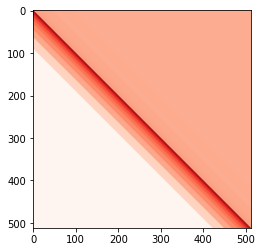

In [51]:
plt.imshow(pos_bias[0][0].detach(), cmap='Reds')

In [ ]:
pos_bias[]

In [ ]:
# rmt.memory_storage

In [62]:
rmt.generate(sample_input_ids)

tensor([[    0, 32099, 32131, 32131, 32131, 32131, 32131, 32131, 32131, 32131,
         32131, 32131, 32131, 32131, 32131, 32131, 32131, 32131, 32131, 32131],
        [    0, 32099, 32128, 32131, 32128, 32131, 32128, 32131, 32128, 32131,
         32128, 32131, 32128, 32131, 32128, 32131, 32128, 32131, 32128, 32131]])

In [54]:
rmt.memory_layers

In [20]:
out = rmt(sample_input_ids, **kwargs, output_hidden_states=True, output_attentions=True)
out.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'decoder_attentions', 'cross_attentions', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions', 'loss_0', 'decoder_hidden_states_0', 'decoder_attentions_0', 'cross_attentions_0', 'encoder_hidden_states_0', 'encoder_attentions_0', 'loss_1', 'decoder_hidden_states_1', 'decoder_attentions_1', 'cross_attentions_1', 'encoder_hidden_states_1', 'encoder_attentions_1', 'loss_2', 'decoder_hidden_states_2', 'decoder_attentions_2', 'cross_attentions_2', 'encoder_hidden_states_2', 'encoder_attentions_2'])

In [52]:
rmt.model.base_model.encoder.get_rel_embedding()

tensor([[-0.1291, -0.0159, -0.0419,  ..., -0.0337, -0.2189, -0.0095],
        [-0.0350, -0.0167,  0.0482,  ..., -0.1350, -0.2535, -0.0246],
        [-0.0531,  0.0108, -0.0384,  ..., -0.1367, -0.1615, -0.0312],
        ...,
        [-0.1999,  0.0540, -0.0645,  ..., -0.1501, -0.1413, -0.0326],
        [-0.2171,  0.0586, -0.0722,  ..., -0.1467, -0.1235, -0.0330],
        [-0.2195,  0.0811, -0.0253,  ..., -0.0988, -0.1056, -0.0275]],
       grad_fn=<NativeLayerNormBackward>)

In [75]:
# memory_input = self.pad_add_special_tokens(self.mem_token_ids, self.input_size)[:self.num_mem_tokens + ]

In [10]:
# mem_out = self.model.base_model(memory_input.reshape((1, -1)))

In [11]:
sample_input_ids.shape

NameError: name 'sample_input_ids' is not defined

In [ ]:
out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
out.keys()

odict_keys(['loss', 'logits', 'hidden_states', 'loss_0', 'loss_1', 'loss_2'])

In [ ]:
# segmented = rmt.pad_and_segment(sample_input_ids[:, :600])

In [19]:
# for n, p in rmt.named_parameters():
#     if 'memory' in n:
#         print(n)

In [20]:
# len(rmt.memory_decoders)

In [21]:
# for n, p in rmt.named_parameters():
#     print(n, p.shape)

### load dataset 

In [14]:
class Holder:
    def __init__(self):
        pass

In [15]:
input_seq_len = 1536
target_seq_len = 1024
batch_size = 2

args = Holder
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

### Encoder-decoder

In [16]:
global_attention_first_token = False  # should be True for LED
encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
generate_kwargs = {}

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    if 'outputs' in batch[0]:
        # if we have more than 1 label per example (only in valid) take only one of them
        # to compute loss on valid
        labels = [b['outputs'][0][:args.target_seq_len * 10] for b in batch]
    else:
        labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), max_length=args.input_seq_len, return_tensors='pt',
                                           **encode_plus_kwargs)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
                                             **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    features['id'] = [b['id'] for b in batch]
    if 'outputs' in batch[0]:
        features['target_text'] = [b['outputs'] for b in batch]
    else:
        features['target_text'] = [b['output'] for b in batch]
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features

In [17]:
task_name = 'qasper'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/qasper/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
gen = iter(train_dataloader)
sample = next(gen)

if 'id' in sample:
    id = sample.pop('id')
if 'target_text' in sample:
    tgt_text = sample.pop('target_text')

rmt.to(device)
for k in sample:
    sample[k] = sample[k].to(device)
    
sample_input_ids = sample.pop('input_ids').to(device)
kwargs = sample

### Encoder

In [31]:
input_seq_len = 1536
target_seq_len = 3
batch_size = 2

args = Holder
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [32]:
encode_plus_kwargs = {'max_length': args.input_seq_len,
                        'truncation': True,
                        'padding': 'longest',
                        'pad_to_multiple_of': 1}
generate_kwargs = {}
labels_map = {'Contradiction': 0, 'Entailment': 1, 'Not mentioned': 2}
num_labels = len(labels_map)

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['input'][:args.input_seq_len * 10] for b in batch]
    labels = [b['output'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs)
    labels = np.array([labels_map[t] for t in labels])
    features['labels'] = torch.from_numpy(labels)
    return features

In [33]:
task_name = 'contract_nli'
dataset = datasets.load_dataset('tau/scrolls', task_name)
train_dataset = dataset['train']

train_sampler = RandomSampler(train_dataset,)
kwargs = {'pin_memory': True, 'num_workers': 0}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

valid_dataset = dataset['validation']
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/contract_nli/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
gen = iter(train_dataloader)
sample = next(gen)

if 'id' in sample:
    id = sample.pop('id')
if 'target_text' in sample:
    tgt_text = sample.pop('target_text')

rmt.to(device)
for k in sample:
    sample[k] = sample[k].to(device)
    
sample_input_ids = sample.pop('input_ids').to(device)
kwargs = sample

In [24]:
out = rmt(sample_input_ids, **kwargs, output_hidden_states=True, output_attentions = True)
out.keys()

ModuleAttributeError: 'BertForSequenceClassification' object has no attribute 'encoder'

### replace forward signature

In [ ]:
import inspect 
from functools import wraps

model_name = "google/bert_uncased_L-4_H-256_A-4"

def decorate(func, source):
    @wraps(source)
    def decorated(*args, **kwargs):
        return func(*args, **kwargs)
    return decorated

class RMT(torch.nn.Module):
    def __init__(self, base_model, **rmt_kwargs):
        super().__init__()
        self.model = base_model
        self.forward = decorate(self.forward, self.model.forward)

    def forward(self, new_rmt_arg, input_ids, **kwargs):
        pass

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
rmt = RMT(base_model, **rmt_config)
inspect.signature(rmt.forward)

In [49]:
from functools import wraps

def wrap_func(method):
    @wraps(method)
    def _impl(self, *method_args, **method_kwargs):
        method_output = method(self, *method_args, **method_kwargs)
        return method_output
    return _impl
    # return 

class RMTEncoderForSequenceClassification(RMTBaseModel):
    def __init__(self, base_model, **rmt_kwargs):
        super().__init__(base_model, **rmt_kwargs)

    @wrap_func
    def forward(self, input_ids, **kwargs):
        memory = self.set_memory()
        memory = memory.repeat(input_ids.shape[0], 1, 1)
        segmented = self.pad_and_segment(input_ids)

        losses = []
        for seg_num, segment_input_ids in enumerate(segmented):                
            if (self.rmt_config['bptt_depth'] > -1) and (len(segmented) - seg_num > self.rmt_config['bptt_depth']): 
                memory = memory.detach()

            seg_kwargs = dict(**kwargs)
            seg_kwargs['output_hidden_states'] = True

            non_empty_mask = [s is not None for s in segment_input_ids]
            if sum(non_empty_mask) == 0:
                continue
            input_ids = torch.stack([s for s in segment_input_ids if s is not None])
            attention_mask = self.get_attention_mask(input_ids)
            token_type_ids = self.get_token_type_ids(input_ids)
            seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]

            inputs_embeds = self.model.embeddings(input_ids)
            inputs_embeds[:, self.memory_position] = memory[non_empty_mask]

            seg_kwargs['input_ids'] = None
            seg_kwargs['inputs_embeds'] = inputs_embeds
            seg_kwargs['attention_mask'] = attention_mask
            seg_kwargs['token_type_ids'] = token_type_ids

            out = self.model(**seg_kwargs)
            memory[non_empty_mask] = out.hidden_states[-1][:, self.memory_position]

            losses.append(out['loss'])

        # drop unnecessary hiddens to save memory
        if not kwargs.get('output_hidden_states'):
            for key in out.keys():
                if 'hidden_state' in key:
                    out[key] = None

        for i, l in enumerate(losses):
            out[f'loss_{i}'] = l.mean()

        if self.rmt_config['sum_loss']:
            out['loss'] = torch.stack(losses).sum(dim=0)

        return out
        
    def pad_add_special_tokens(self, tensor, segment_size):
        input_elements = []
        input_elements += [self.cls_token, self.mem_token_ids, self.sep_token, tensor, self.sep_token]
        tensor = torch.cat(input_elements)

        pad_size = segment_size - tensor.shape[0]
        if pad_size > 0:
            tensor = F.pad(tensor, (0, pad_size))
        return tensor
    
    def get_token_type_ids(self, tensor):
        return torch.zeros_like(tensor)


num_segments = 2
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'


from rmt_utils.encoder.memory_layers import memory_layers_forward as memory_layers_func
# from rmt_utils.encoder.memory_layers import deberta_memory_layers_forward as memory_layers_func

model_name = "google/bert_uncased_L-4_H-256_A-4"
# model_name = "microsoft/deberta-v3-base"
# model_name = 'google/electra-base-discriminator'
# model_name = "google/bert_uncased_L-4_H-256_A-4"

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': 5, 
                'max_n_segments': 3,
               #  'segment_alignment': 'right',
                'tokenizer': tokenizer,
                'memory_layers': 'all', 
                'memory_forward_func': memory_layers_func,
                'share_memory_layers': True,
                'reconstruction_loss_coef': 1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
rmt = RMTEncoderForSequenceClassification(base_model, **rmt_config)
# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt.to(device)

import inspect
inspect.signature(rmt.forward)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

<Signature (input_ids, **kwargs)>

### MLM head for input decoding 

In [140]:
self.model.bert.encoder.layer[-1]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=256, out_features=256, bias=True)
      (key): Linear(in_features=256, out_features=256, bias=True)
      (value): Linear(in_features=256, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=256, out_features=256, bias=True)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=256, out_features=1024, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=1024, out_features=256, bias=True)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [247]:
self.rec_attn = copy.deepcopy(self.model.base_model.encoder.layer[-1])
self.rec_cls = torch.nn.Linear(self.model.config.hidden_size, self.model.config.vocab_size)

In [146]:
rec_kwargs = dict(**kwargs)
rec_kwargs.pop('labels')
# rec_kwargs.pop('token_type')

tensor([2, 1])

In [269]:
mlm_prob = 0.15

segmented = self.pad_and_segment(sample_input_ids)
previous_input_ids = segmented[0]

inputs = torch.stack(previous_input_ids)
input_embeddings = self.model.embeddings(inputs)

out = self.model(inputs_embeds=input_embeddings, output_hidden_states=True)
memory_outputs = out['hidden_states'][-1][:, self.memory_position]


In [271]:
def reconstruction_forward(self, memory_outputs, previous_input_ids):
    
    inputs = torch.stack(previous_input_ids)
    input_embeddings = self.model.embeddings(inputs)
    input_embeddings[:, self.memory_position] = memory_outputs

    token_inds = list(range(self.num_mem_tokens + 2, input_embeddings.shape[1] - 1))
    mask_inds = np.random.choice(token_inds, round(len(token_inds) * mlm_prob))
    attention_mask = torch.ones(input_embeddings.shape[1])
    attention_mask[mask_inds] = 0

    rec_attn_out = self.rec_attn(input_embeddings)
    rec_logits = self.rec_cls(rec_attn_out[0])

    loss_fct = CrossEntropyLoss(ignore_index=-100)
    reconstruction_loss = loss_fct(rec_logits.view(-1, rec_logits.size(-1)), inputs.view(-1))
    
    return reconstruction_loss

In [272]:
reconstruction_forward(self, memory_outputs=memory_outputs, previous_input_ids=segmented[0])

tensor(10.4209, grad_fn=<NllLossBackward>)

In [254]:
token_inds = list(range(self.num_mem_tokens + 2, input_embeddings.shape[1] - 1))
mask_inds = np.random.choice(token_inds, round(len(token_inds) * mlm_prob))

In [266]:
attention_mask = torch.ones(input_embeddings.shape[1])
attention_mask[mask_inds] = 0


In [267]:
rec_attn_out = self.rec_attn(input_embeddings)
rec_logits = self.rec_cls(rec_attn_out[0])
rec_logits.shape

torch.Size([2, 512, 30527])

In [268]:
loss_fct = CrossEntropyLoss(ignore_index=-100)
reconstruction_loss = loss_fct(rec_logits.view(-1, rec_logits.size(-1)), inputs.view(-1))
reconstruction_loss

tensor(10.4209, grad_fn=<NllLossBackward>)

In [207]:
input_embeddings.shape

torch.Size([2, 512, 256])

In [239]:
token_inds = list(range(self.num_mem_tokens + 2, input_embeddings.shape[1] - 1))

In [240]:
np.random.shuffle(token_inds)
mask_inds = token_inds[: round(len(token_inds) * mlm_prob) ]

In [ ]:
input_a

In [ ]:
random_mask_inds = torch.randa


In [203]:
input_embeddings

tensor([[[-0.0159,  0.0027,  0.0078,  ...,  0.0175, -0.0240,  0.0109],
         [ 0.0315, -0.0055,  0.0017,  ...,  0.0132, -0.0214, -0.0158],
         [ 0.0016, -0.0042, -0.0412,  ...,  0.0192,  0.0082, -0.0007],
         ...,
         [-0.0986,  0.0014, -0.0430,  ..., -0.0016, -0.0158, -0.0046],
         [-0.0986,  0.0014, -0.0430,  ..., -0.0016, -0.0158, -0.0046],
         [-0.0986,  0.0014, -0.0430,  ..., -0.0016, -0.0158, -0.0046]],

        [[-0.0159,  0.0027,  0.0078,  ...,  0.0175, -0.0240,  0.0109],
         [ 0.0315, -0.0055,  0.0017,  ...,  0.0132, -0.0214, -0.0158],
         [ 0.0016, -0.0042, -0.0412,  ...,  0.0192,  0.0082, -0.0007],
         ...,
         [-0.0226,  0.0497,  0.0308,  ..., -0.0470, -0.0116,  0.0216],
         [-0.0381, -0.0252,  0.0037,  ...,  0.0464,  0.0336,  0.0329],
         [-0.0637, -0.0239,  0.0430,  ..., -0.0894,  0.0181,  0.0181]]],
       grad_fn=<EmbeddingBackward>)

In [148]:
rec_kwargs['token_type_ids'].shapea

torch.Size([2, 1536])

In [142]:
sample_input_ids

tensor([[ 101, 4909, 2283,  ...,    0,    0,    0],
        [ 101, 4909, 2283,  ..., 2023, 3820,  102]])

In [201]:
# from torch.nn import CrossEntropyLoss
# # def segment_reconstruction_forward(self, segmented, hidden_states):

# hidden_states = rec_kwargs['inputs_embeds']
# previous_input_ids = segmented[-2]
# non_empty_mask = [s is not None for s in previous_input_ids]
# if sum(non_empty_mask) == 0:
#     raise ValueError

# previous_input_ids = torch.stack(previous_input_ids)[non_empty_mask]
# reconstructor_input = hidden_states[non_empty_mask]

# rec_attn_out = self.rec_attn(reconstructor_input)
# rec_logits = self.rec_cls(rec_attn_out[0])

# loss_fct = CrossEntropyLoss(ignore_index=-100)
# reconstruction_loss = loss_fct(rec_logits.view(-1, rec_logits.size(-1)), previous_input_ids.view(-1))

### segment to memory attribution

In [18]:
self = rmt
input_ids = sample_input_ids

In [19]:
# memory = self.set_memory()
# memory = memory.repeat(input_ids.shape[0], 1, 1)
# segmented = self.pad_and_segment(input_ids)

# losses = {}
# memories = []
# inputs = []
# non_memory_position = [i for i in range(self.rmt_config['input_size']) if i not in self.memory_position]

# for seg_num, segment_input_ids in enumerate(segmented):
#     if (self.rmt_config['bptt_depth'] > -1) and (len(segmented) - seg_num > self.rmt_config['bptt_depth']): 
#         memory = memory.detach()

#     seg_kwargs = dict(**kwargs)
#     seg_kwargs['output_hidden_states'] = True
    
#     non_empty_mask = [s is not None for s in segment_input_ids]
#     if sum(non_empty_mask) == 0:
#         continue
#     input_ids = torch.stack(segment_input_ids)[non_empty_mask]
#     attention_mask = self.get_attention_mask(input_ids)
#     token_type_ids = self.get_token_type_ids(input_ids)
#     seg_kwargs['labels'] = seg_kwargs['labels'][non_empty_mask]

#     inputs_embeds = self.embeddings(input_ids)
#     inputs_embeds[:, self.memory_position] = memory[non_empty_mask]

#     seg_kwargs['inputs_embeds'] = inputs_embeds
#     seg_kwargs['attention_mask'] = attention_mask
        
#     out = self.model.forward(**seg_kwargs)

#     memory[non_empty_mask] = out.encoder_hidden_states[-1][:, self.memory_position]
    
#     memories.append(torch.clone(memory[non_empty_mask].detach()))
#     inputs.append(out.encoder_hidden_states[-1][:, non_memory_position])

#     losses[f'loss_{seg_num}'] = out['loss']

# memory_out = out.encoder_last_hidden_state[:, self.memory_position]
# reconstruction_loss = self.segment_reconstruction_forward(segmented, memory_out)
# out['reconstruction_loss'] = reconstruction_loss

# # drop unnecessary hiddens to save memory
# # if not kwargs.get('output_hidden_states'):
# #     for key in out.keys():
# #         if 'hidden_state' in key:
# #             out[key] = None
            
# for k, loss in losses.items():
#     out[k] = loss

# if self.rmt_config['sum_loss']:
#     out['loss'] = torch.stack(losses).sum(dim=0)

# rec_coef = self.rmt_config['reconstruction_loss_coef']
# out['loss'] = reconstruction_loss * rec_coef + out['loss'] * (1 - rec_coef)